In [39]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
#import mplleaflet as mpll
import pylab as plt
import json
import pycrs

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import pandana
from pandana.loaders import osm

import GOSTnet as gn

In [58]:
import folium

# Accessibility in Ulaan Baatar

In [40]:
boundary_GDF = ox.gdf_from_place('Ulaan Baatar',which_result=0)
boundary_GDF

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,107.578164,48.257157,47.635288,106.356383,"POLYGON ((106.356383 48.257157, 106.376367 48....","Ulaanbaatar, Mongolia"


In [41]:
boundary_poly = boundary_GDF.loc[0,'geometry']
bbox = boundary_poly.bounds

/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


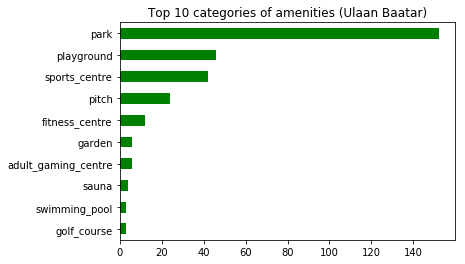

In [53]:
# RESIDENTIAL AMENITIES

residential_amenities = ['restaurant','bank','atm','cafe','bus_station','fast_food','pharmacy','school',
                        'kindergarten','pub','hospital','bar','marketplace','dentist','place_of_worship']

residential_shops = ['supermarket','yes','hairdresser','convenience','clothes','beauty','bakery']
residential_leisure = ['park','playground','sports_centre','pitch']

POIs_res_amenity = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(residential_amenities)))
POIs_res_shop = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"shop"~"{}"'.format('|'.join(residential_shops)))
POIs_res_leisure = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"leisure"~"{}"'.format('|'.join(residential_leisure)))

POIs_res_amenity = POIs_res_amenity[['amenity','name','lat','lon']]
POIs_res_amenity.rename(columns={'amenity':'type'},inplace=True)

POIs_res_shop = POIs_res_shop[['shop','name','lat','lon']]
POIs_res_shop.rename(columns={'shop':'type'},inplace=True)

POIs_res_leisure = POIs_res_leisure[['leisure','name','lat','lon']]
POIs_res_leisure.rename(columns={'office':'type'},inplace=True)

pois_res = POIs_res_amenity.append(POIs_res_shop)
pois_res = pois_res.append(POIs_res_leisure)

In [121]:
pois.type.value_counts()[:12]

bank            257
atm             176
bus_station     171
fuel            146
company          99
government       54
marketplace      49
car_repair       35
mobile_phone     32
computer         23
kiosk            23
car              22
Name: type, dtype: int64

In [111]:
# BUSINESS AMENITIES

amenities = ['bank','atm','bus_station','fuel','marketplace']

shops = ['car_repair','mobile_phone','kiosk','computer','car','travel_agency','stationery']

offices = ['company','government','insurance','lawyer','telecommunication','financial','it','notary',]

POIs_amenity = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities)))
POIs_shop = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"shop"~"{}"'.format('|'.join(shops)))
POIs_office = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"office"~"{}"'.format('|'.join(offices)))

In [112]:
POIs_amenity = POIs_amenity[['amenity','name','lat','lon']]
POIs_amenity.rename(columns={'amenity':'type'},inplace=True)

POIs_shop = POIs_shop[['shop','name','lat','lon']]
POIs_shop.rename(columns={'shop':'type'},inplace=True)

POIs_office = POIs_office[['office','name','lat','lon']]
POIs_office.rename(columns={'office':'type'},inplace=True)

In [113]:
pois = POIs_amenity.append(POIs_shop)
pois = pois.append(POIs_office)

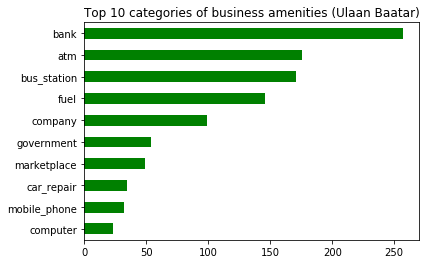

In [114]:
pois.type.value_counts()[:10].plot(kind='barh',title='Top 10 categories of business amenities (Ulaan Baatar)',color='g')
plt.gca().invert_yaxis()

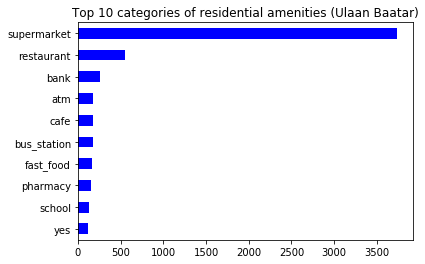

In [118]:
pois_res.type.value_counts()[:10].plot(kind='barh',title='Top 10 categories of residential amenities (Ulaan Baatar)',color='b')
plt.gca().invert_yaxis()

In [119]:
pois_res.shape

(6744, 5)

In [116]:
pois.to_csv('pois_business.csv')

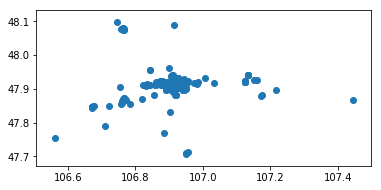

In [109]:
pois = gpd.GeoDataFrame(pois)
pois['geometry'] = (list(zip(pois.lon,pois.lat)))
pois['geometry'] = pois.geometry.apply(lambda x: Point(x))
pois.plot()

In [12]:
from mapboxgl.utils import *
from mapboxgl.viz import *

In [11]:
token = "pk.eyJ1Ijoibmo5MzUiLCJhIjoiY2pzOW1pdGluMGVpeTN5bnhyZHRpcHdycSJ9.uQWY2hDAjKaxMQsoOzwfSQ"

In [87]:
pois_res.columns
heat_data = [[row['lat'],row['lon']] for index, row in pois_res.iterrows()]

In [108]:
pois_res.to_csv('pois_res')

In [88]:
from folium.plugins import HeatMap

In [94]:
m = folium.Map(location = [pois_res.lat.mean(), pois_res.lon.mean()],
              zoom_start = 12,height = 400)

HeatMap(heat_data,min_opacity=0.2).add_to(m)
m

In [95]:
token = "pk.eyJ1Ijoibmo5MzUiLCJhIjoiY2pzOW1pdGluMGVpeTN5bnhyZHRpcHdycSJ9.uQWY2hDAjKaxMQsoOzwfSQ"

In [ ]:
df_to_geojson(pois_res, filename='pois_res.geojson',
              lat='lat', lon='lon', precision=3)



In [102]:
from mapboxgl.utils import create_color_stops, df_to_geojson
from mapboxgl.viz import CircleViz


# Load data from sample csv
data_url = 'https://raw.githubusercontent.com/mapbox/mapboxgl-jupyter/master/examples/data/points.csv'
df = pd.read_csv(data_url)

# Must be a public token, starting with `pk`


# Create a geojson file export from a Pandas dataframe
df_to_geojson(df, filename='points.geojson',
              properties=['Avg Medicare Payments', 'Avg Covered Charges', 'date'],
              lat='lat', lon='lon', precision=3)

# Generate data breaks and color stops from colorBrewer
color_breaks = [0,10,100,1000,10000]
color_stops = create_color_stops(color_breaks, colors='YlGnBu')

# Create the viz from the dataframe
viz = CircleViz('points.geojson',
                access_token=token,
                height='400px',
                color_property = "Avg Medicare Payments",
                color_stops = color_stops,
                center = (107.9,47.8),
                zoom = 3,
                below_layer = 'waterway-label'
              )
viz.show()

In [106]:
v = CircleViz(data = 'pois_res.geojson',
              access_token=token,
              center = (107.9,47.8),
              height = '400px',
              style="Light-TW/style.json",
              zoom=3,
              radius = 2.5,
                label_color = '#69F0AE',
                color_default='#69F0AE',
                stroke_color='#ffffff',
             below_layer = 'waterway-label')
v.show()